# Methods of Images Contrast Enhancement
## NLA course project

### Snayperskaya Vintovka Dragunova - SVD


## 1. Problem statement 

**Have**: Brain magnetic resonance images


**Problem**: Images affected by noise, artefacts, speckles, poor quality, low contarast


**To do**: Make image more contrasted

## Formal problem statement 

**Given**: $A$ - $2$-dimensional array with size $256 \times 256$. $~~a_{ij}$ - color value of pixel $(i,j)$, $~~a_{ij} \in [0,255]$, where $0$ is black and $255$ is white.


**Output**: $\hat A = F(A)~-~$ transformed $2$-dimensional array with size $256 \times 256$, which minimizes the metric $Q$:

$$\min_{F} Q(\hat A,A),$$

where $Q \in \{\mathbf{PSNR}, \mathbf{QRCM}, \mathbf{SSIM}, \mathbf{FSIM}, \mathbf{AMBE}, \mathbf{EME}\}~$ and $F$ is an enhancement transformation.

In [4]:
#! pip install image-similarity-measures

In [10]:
import nibabel as nib
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from pathlib import Path
from ipywidgets import IntSlider, interact
import pywt
import cv2
import dicom2nifti
#from skimage import exposure
#from image_similarity_measures.quality_metrics import fsim

In [11]:
def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(12,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [ ]:
#convert dicom to nii.gz
#dicom2nifti.dicom_series_to_nifti('0_1', '0_1.nii.gz', reorient_nifti=True)

In [12]:
#download 3d brain image
brain = nib.load('0_1.nii.gz')

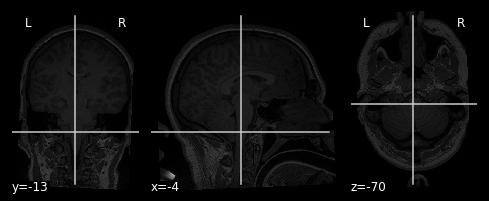

In [15]:
plot_anat(brain);

In [13]:
brain = brain.get_fdata()
brain.shape

(192, 352, 352)

In [14]:
sld_sagital = IntSlider(min=0, max=brain.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=brain.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=brain.shape[2]-1, step=1, continuous_update=True)

In [15]:
def vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_img(brain[coordinate_sagital,:,:])
    if axis == 'coronal':
        plot_img(brain[:,coordinate_coronal ,:])
    if axis == 'axial':
        plot_img(brain[:,:, coordinate_axial])

## Example of brain MRI

In [16]:
interact(vary_coordinate, 
         coordinate_axial = sld_axial,
         coordinate_sagital = sld_sagital,
         coordinate_coronal = sld_coronal,
         axis = 'axial');

interactive(children=(IntSlider(value=0, description='coordinate_sagital', max=191), IntSlider(value=0, descri…

In [24]:
#We consider only one slice
A1 = brain[:,:,225].T

In [25]:
print(f'mean = {A1.mean()}')
print(f'variance = {A1.var()}')

mean = 211.5997869318182
variance = 25163.32228096786


## 2 . Ideas and mathematical description of the algorithms

## 2.1 Histogram Equalization

- The technique which includes the transformation $T(i) = 255\cdot cdf(i)$, where $cdf~-~$ cumulative sum of all the probabilities.

$$cdf(x)=\sum\limits_{k = 0}^{x}p_k$$

$$p_k=\frac{number\ of\ pixels\ with\ intensity\ k}{total\ number\ of\ pixels},~~~k=0,1,\dots,255$$


We apply the GHE method to low contrast T1-w (**A1**) brain MRI in order to have equalized images referred as **A2**.

### Histogram equalisation example
![Histogram equalisation example](images_for_report/he.png)

In [26]:
A1_to_cv = np.uint8(cv2.normalize(A1, None, 0, 255, cv2.NORM_MINMAX))
A2 = cv2.equalizeHist(A1_to_cv)

In [27]:
#Local histogram equalization
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#A2 = clahe.apply(A1_to_cv)

In [28]:
print(f'mean = {A2.mean()}')
print(f'variance = {A2.var()}')

mean = 124.1417939157197
variance = 5620.130063164442


In [29]:
A1 = cv2.resize(A1, (256, 256))
A2 = cv2.resize(A2, (256, 256))

## 2.2 Discrete wavelet transform

* Discrete wavelet transform (DWT) - technique for analysis, de-noising and compression of signals and images. 
* Advantage -  can choose the signal’s coefficients with a significant energy and discards the others that have a very low percentage of all energy.
* Daubechie wavelet functions used: $~9/7$ tap and $~1$ tap.
* Obtain four frequency sub-bands **LL**, **LH**, **HL**, **HH** for **A1** and **A2**.

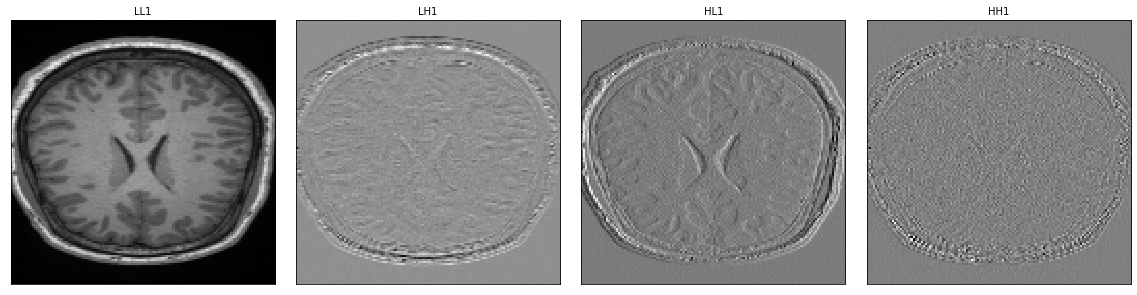

In [49]:
titles = ['LL1', 'LH1', 'HL1', 'HH1']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A1, w)

LL1, (LH1, HL1, HH1) = coeffs

fig = plt.figure(figsize=(16, 4))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

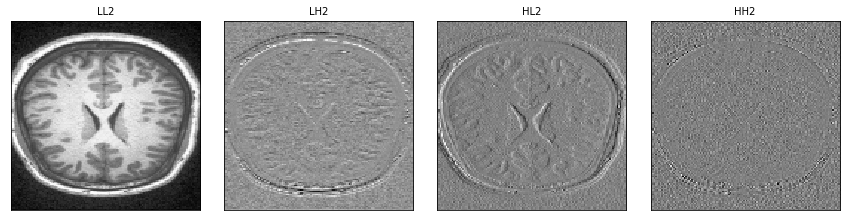

In [31]:
titles = ['LL2', 'LH2', 'HL2', 'HH2']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A2, w)

LL2, (LH2, HL2, HH2) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL2, LH2, HL2, HH2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


## 2.3 Singular value decomposition

Singular Value Decomposition (SVD): any matrix $A \in \mathbb{C}^{n \times m}$ can be represented as the product of three matrices:

$$A = U \cdot \Sigma \cdot V^*$$

where $U,V$ are unitary and $\Sigma$ is diagonal with singular values of $A$ on the diagonal.

* **LL** - intensity information
* **LH**, **HL**, **HH** - edge information
* Hence, apply SVD to **LL** subbands to modify intensity and protect edges

In [32]:
U1, S1, V1 = np.linalg.svd(LL1, full_matrices = False)
U2, S2, V2 = np.linalg.svd(LL2, full_matrices = False)

## Modifying intensity

* Singular value matrix contains intensity information $~\Rightarrow~$ update it
* Correction coefficient $\xi$

**In 2014, Bhandari**

$$\xi = \frac{\max{(U_{LL2}})}{\max{(U_{LL1}})}~~~ \Rightarrow~~~ \Sigma = \xi\cdot\Sigma_{LL2}$$

**In 2015, Randa Atta**

$$\xi = \frac{\max{(\Sigma_{LL2}})}{\max{(\Sigma_{LL1}})}~~~ \Rightarrow~~~ \Sigma = 0.5\cdot(\xi\cdot \Sigma_{LL1}+\frac{1}{\xi}\cdot \Sigma_{LL2})$$

**In 2016, Bhandari**

$$\xi = \frac{\max{(U_{LL2})}+\max{(V_{LL2}})}{\max{(U_{LL1})}+\max{(V_{LL1})}}~~~ \Rightarrow~~~ \Sigma = \xi\cdot \Sigma_{LL2}$$

**In 2019, M. Sahnoun**

$$\xi = \frac{\max{(U_{LL2})}+\max{(V_{LL2}})}{\max{(U_{LL1})}+\max{(V_{LL1})}}~~~ \Rightarrow~~~ \Sigma = \mu\cdot\xi\cdot \Sigma_{LL1}+(1-\mu)\cdot\frac{1}{\xi}\cdot \Sigma_{LL2}$$

## Different methods of finding $\xi$

In [33]:
xi_1 = S2[0]/S1[0]

In [34]:
xi_2 = U2.max()/U1.max()

In [35]:
xi_3 = (U2.max() + V2.max())/(U1.max() + V1.max())

## New $\Sigma$ 

In [36]:
def new_sigma1(sigma2, xi):
    return xi*sigma2

In [37]:
def new_sigma2(sigma1, sigma2, xi):
    return 0.5*(xi*sigma1+sigma2/xi)

In [38]:
def new_sigma3(sigma1, sigma2, xi, mu):
    return mu*xi*sigma1 + (1-mu)*sigma2/xi

## Reconstracting image

**ISVD**:

$$LL = U_{LL2}\Sigma V_{LL2}^*$$

**IDWT**:

$$\hat{A}2 = \mathbf{IDWT}(LL2,LH2,HL2,HH2)$$

In [39]:
def new_LL(new_sigma):
    new_sigma = np.diag(new_sigma)
    return U2 @ new_sigma @ V2

## Workflow

![wf1](images_for_report/wf1.jpg)

[source](https://www.sciencedirect.com/science/article/pii/S1959031819301290)

![wf2](images_for_report/wf2.jpg)

[source](https://www.sciencedirect.com/science/article/pii/S1959031819301290)

## 3. Experiments

**In 2014, Bhandari**

$$\xi = \frac{\max{(U_{LL2}})}{\max{(U_{LL1}})}~~~ \Rightarrow~~~ \Sigma = \xi\cdot\Sigma_{LL2}$$

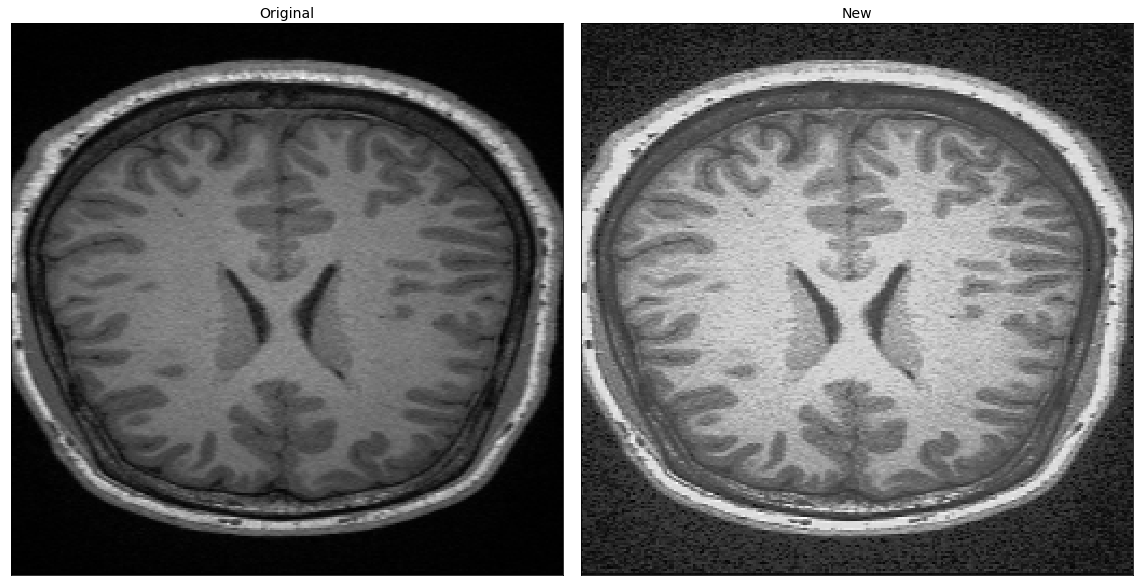

In [82]:
new_S = new_sigma1(S2, xi_2)
LL = new_LL(new_S)
brain1 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [83]:
brain1 = brain1 + np.abs(brain1.min())
brain1 = brain1/brain1.max()

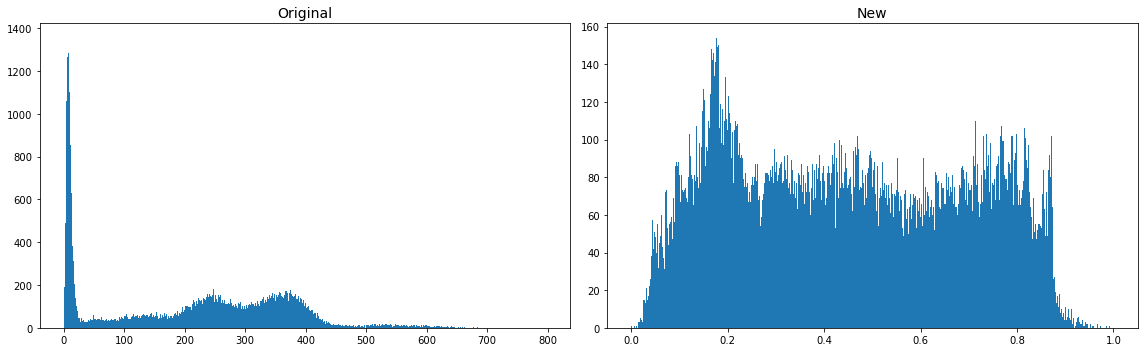

In [84]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

**In 2015, Randa Atta**

$$\xi = \frac{\max{(\Sigma_{LL2}})}{\max{(\Sigma_{LL1}})}~~~ \Rightarrow~~~ \Sigma = 0.5\cdot(\xi\cdot \Sigma_{LL1}+\frac{1}{\xi}\cdot \Sigma_{LL2})$$

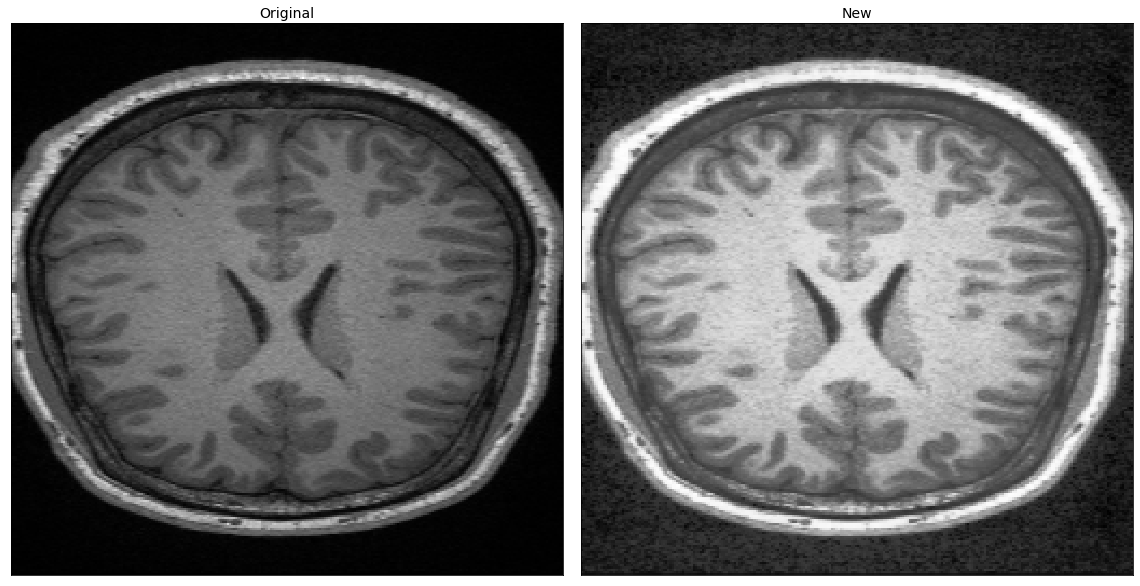

In [85]:
new_S = new_sigma2(S1, S2, xi_3)
LL = new_LL(new_S)
brain2 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [86]:
brain2 = brain2 + np.abs(brain2.min())
brain2 = brain2/brain2.max()

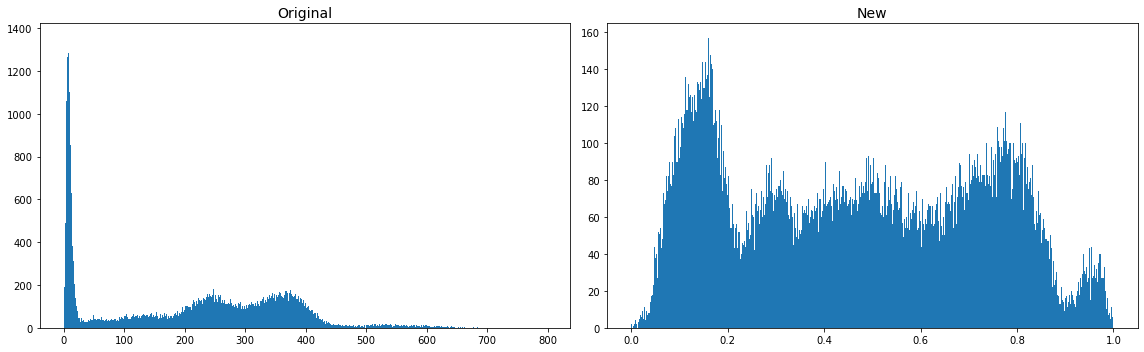

In [87]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

**In 2016, Bhandari**

$$\xi = \frac{\max{(U_{LL2})}+\max{(V_{LL2}})}{\max{(U_{LL1})}+\max{(V_{LL1})}}~~~ \Rightarrow~~~ \Sigma = \xi\cdot \Sigma_{LL2}$$

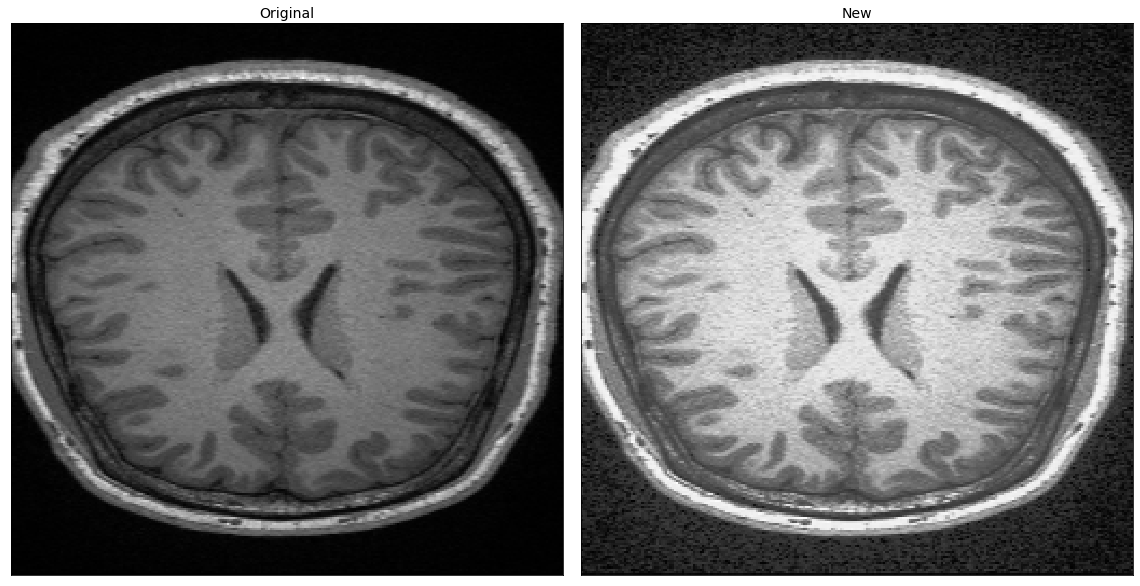

In [88]:
new_S = new_sigma1(S2, xi_3)
LL = new_LL(new_S)
brain3 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [89]:
brain3 = brain3 + np.abs(brain1.min())
brain3 = brain3/brain3.max()

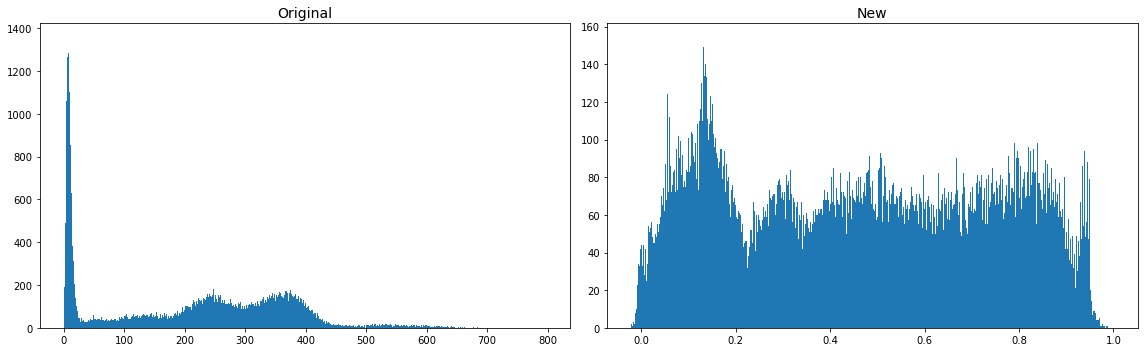

In [90]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

**In 2019, M. Sahnoun**

$$\xi = \frac{\max{(U_{LL2})}+\max{(V_{LL2}})}{\max{(U_{LL1})}+\max{(V_{LL1})}}~~~ \Rightarrow~~~ \Sigma = \mu\cdot\xi\cdot \Sigma_{LL1}+(1-\mu)\cdot\frac{1}{\xi}\cdot \Sigma_{LL2}$$

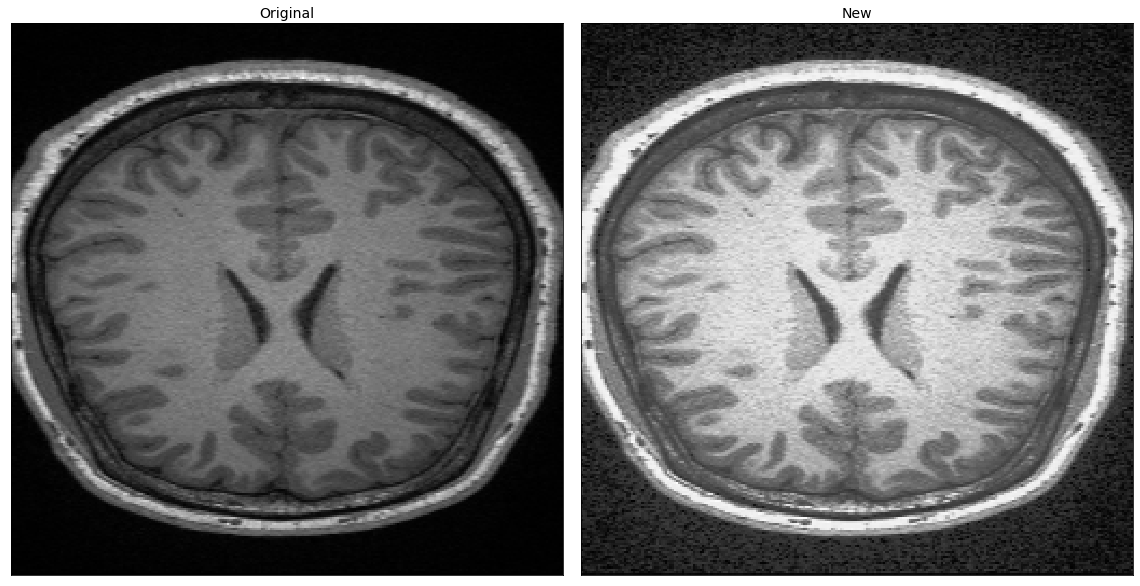

In [95]:
mu = 0.1
new_S = new_sigma3(S1, S2, xi_3, mu)
LL = new_LL(new_S)
brain4 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [96]:
brain4 = brain4 + np.abs(brain3.min())
brain4 = brain4/brain3.max()

In [97]:
brains_4 = []
for mu in np.linspace(0,1, 20):
    new_S = new_sigma3(S1, S2, xi_3, mu)
    LL = new_LL(new_S)
    brain = pywt.idwt2((LL, (LH2, HL2, HH2)), w)
    brain = brain + np.abs(brain.min())
    brain = brain/brain.max()
    brains_4.append(brain)

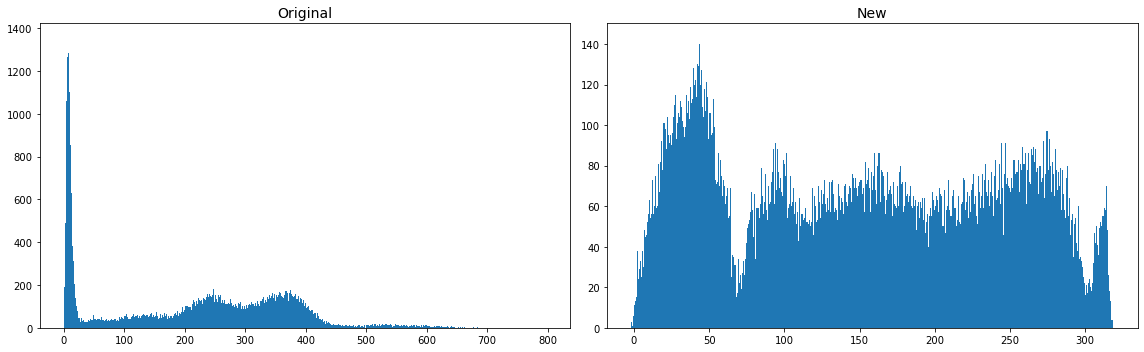

In [98]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain4]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

## 4. Alternative methods

* Histogram Equalization
* Adaptive Histogram Equalization
* Contrast stretching

Simple image enhancement technique which improves the contrast in an image by "stretching" the range of intensity values it contains to span a desired range of values.

Algorithm scans the image to find the lowest ($c$) and highest ($d$) pixel values Each pixel color $i$ is scaled using in the following way:

$$T(i) = (i-c)\cdot\frac{b-a}{d-c} + a$$

<img src="images_for_report/contraststretching.png" alt="Drawing" style="width: 1000px;"/>

In [ ]:
image = A1/A1.max()
image_eq = exposure.equalize_hist(image)
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
pd, pu = np.percentile(image, (8, 92))
image_rescale = exposure.rescale_intensity(image, in_range=(pd, pu))


fig, axs = plt.subplots(2, 4,figsize = (15,7))
axs[0, 0].imshow(image, cmap = 'gray')
axs[0, 0].set_title('Original image')
axs[0, 1].imshow(image_eq, cmap = 'gray')
axs[0, 1].set_title('Histogram Equalization')
axs[0, 2].set_title('Adaptive Histogram Equalization')
axs[0, 2].imshow(image_adapteq, cmap = 'gray')
axs[0, 3].set_title('Contrast stretching')
axs[0, 3].imshow(image_rescale, cmap = 'gray')
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[0,3].axis('off')

axs[1, 0].hist(image.reshape(-1), bins = 400)
axs[1, 1].hist(image_eq.reshape(-1), bins = 400)
axs[1, 2].hist(image_adapteq.reshape(-1), bins = 400)
axs[1, 3].hist(image_rescale.reshape(-1), bins = 400);
axs[1,3].set_ylim(0,1750);

![metrics](brains_.png)

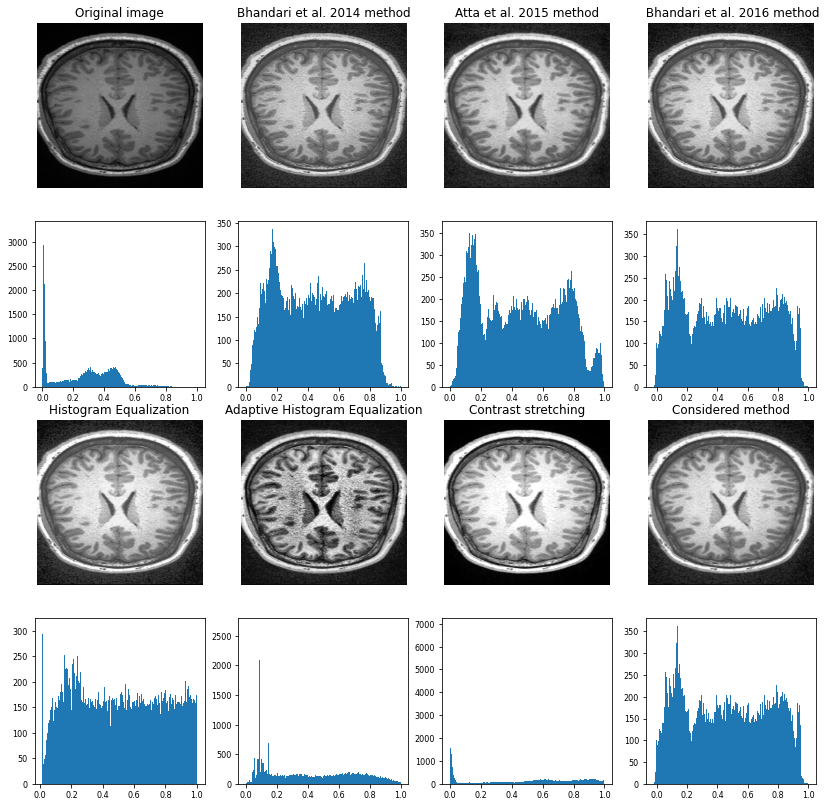

In [110]:
# brain1 = (brain1 - brain1.min())/(brain1.max() - brain1.min())
# brain2 = (brain2 - brain2.min())/(brain2.max() - brain2.min())
# brain3 = (brain3 - brain3.min())/(brain3.max() - brain3.min())
# brain4 = (brain4 - brain4.min())/(brain4.max() - brain3.min())

plt.rc('font', size = 8)
fig, axs = plt.subplots(4, 4,figsize = (14,14))
axs[0, 0].imshow(image, cmap = 'gray')
axs[0, 0].set_title('Original image', fontsize = 12)
axs[0, 0].axis('off')
axs[0, 1].imshow(brain1, cmap = 'gray')
axs[0, 1].set_title('Bhandari et al. 2014 method', fontsize = 12)
axs[0, 1].axis('off')

axs[0, 2].set_title('Atta et al. 2015 method', fontsize = 12)
axs[0, 2].imshow(brain2, cmap = 'gray')
axs[0, 2].axis('off')

axs[0, 3].set_title(' Bhandari et al. 2016 method', fontsize = 12)
axs[0, 3].imshow(brain3, cmap = 'gray')
axs[0, 3].axis('off')

axs[2, 3].set_title('Considered method', fontsize = 12)
axs[2, 3].imshow(brain4, cmap = 'gray')
axs[2, 3].axis('off')

axs[1, 0].hist(image.reshape(-1), bins = 400)
axs[1, 1].hist(brain1.reshape(-1), bins = 400)
axs[1, 2].hist(brain2.reshape(-1), bins = 400)
axs[1, 3].hist(brain3.reshape(-1), bins = 400)


axs[2, 0].set_title('Histogram Equalization', fontsize = 12)
axs[2, 0].imshow(image_eq, cmap = 'gray')
axs[2, 0].axis('off')
axs[2, 1].set_title('Adaptive Histogram Equalization', fontsize = 12)
axs[2, 1].imshow(image_adapteq, cmap = 'gray')
axs[2, 1].axis('off')
axs[2, 2].set_title('Contrast stretching', fontsize = 12)
axs[2, 2].imshow(image_rescale, cmap = 'gray')
axs[2, 2].axis('off')
axs[0, 3].axis('off')

axs[3, 0].hist(image_eq.reshape(-1), bins = 400)
axs[3, 1].hist(image_adapteq.reshape(-1), bins = 400)
axs[3, 2].hist(image_rescale.reshape(-1), bins = 400)
axs[3, 3].hist(brain3.reshape(-1), bins = 400);
plt.savefig('images_for_report/images_hists1.png');

## 5. Quality evaluation

* Measure of Peak Signal-to-Noise Ratio (PSNR)
* Measure of Quality-aware Relative Contrast Measure (QRCM)
* Structure similarity index measurement (SSIM)
* Feature similarity index measurement (FSIM)
* Absolute Mean Brightness Error (AMBE) 
* Measure of enhancement by entropy (EME)

![metrics](images_for_report/metrics1.png)

In [36]:
from metrics import psnr, qrcm, ssim, EME, AMBE

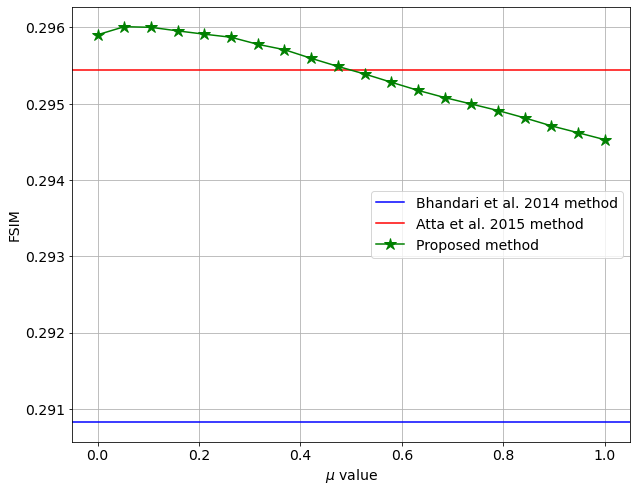

In [46]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(fsim(A1.reshape(256,256,1),brain1.reshape(256,256,1)), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(fsim(A1.reshape(256,256,1),brain2.reshape(256,256,1)), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [fsim(A1.reshape(256,256,1),x.reshape(256,256,1)) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('FSIM')
plt.grid(True)
plt.show()

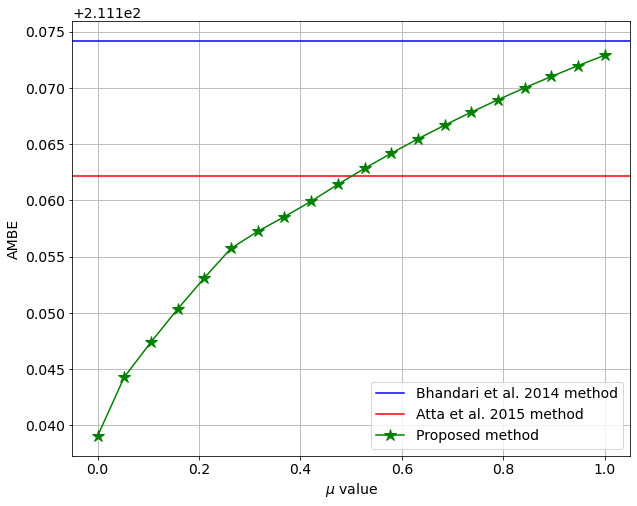

In [37]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(AMBE(brain1,A1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(AMBE(brain2,A1), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [AMBE(x,A1) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('AMBE')
plt.grid(True)
plt.show()

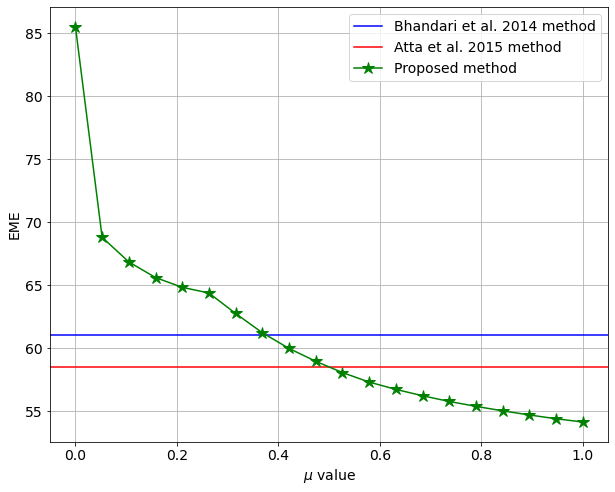

In [134]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(EME(brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(EME(brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [EME(x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('EME')
plt.grid(True)
plt.show()

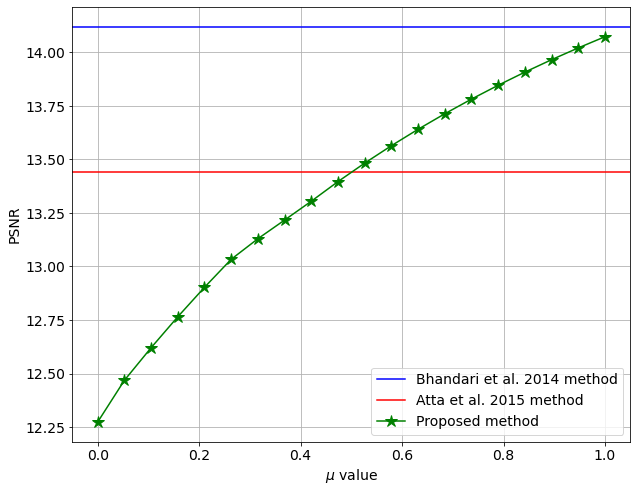

In [34]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(psnr(A1, brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(psnr(A1, brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [psnr(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

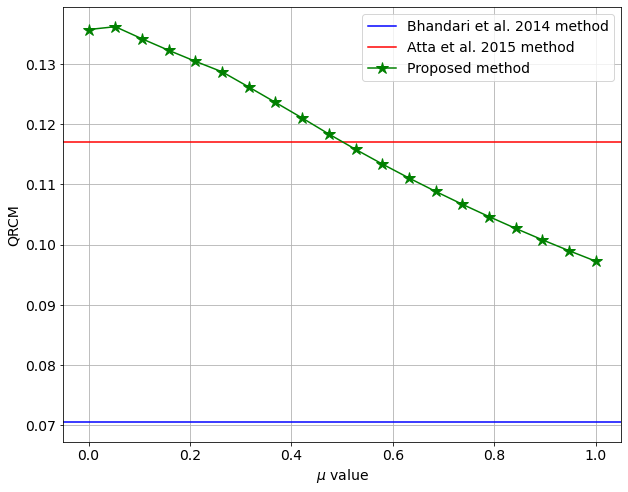

In [35]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(qrcm(A1, brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(qrcm(A1, brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [qrcm(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('QRCM')
plt.grid(True)
plt.show()

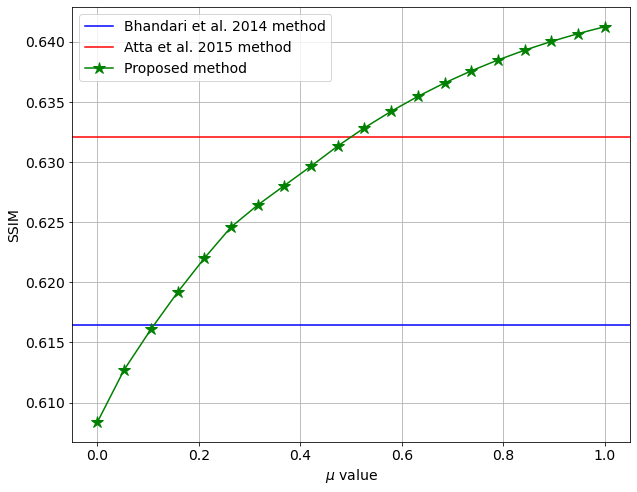

In [36]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(ssim(A1, brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(ssim(A1, brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [ssim(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('SSIM')
plt.grid(True)
plt.show()

# 6. Time measurement

* **HE** based methods, contrast stretching - $O(n^2)$
* Methods with SVD decomposition - $O(n^3)$
* But numerical experiments show - $32$ fps $\Rightarrow$ method suitable for real-time enhancement

In [104]:
w = pywt.Wavelet('db1')
mu = 0.1

In [105]:
%%timeit -r 10
A2 = (A1 - A1.min())/(A1.max() - A1.min())
coeffs = pywt.dwt2(A1, w)
LL1, (LH1, HL1, HH1) = coeffs
coeffs = pywt.dwt2(A2, w)
LL2, (LH2, HL2, HH2) = coeffs
U1, S1, V1 = np.linalg.svd(LL1, full_matrices = False)
U2, S2, V2 = np.linalg.svd(LL2, full_matrices = False)
xi_3 = (U2.max() + V2.max())/(U1.max() + V1.max())
new_S = new_sigma3(S1, S2, xi_3, mu)
new_sigma = np.diag(new_S)
LL = U2 @ new_sigma @ V2
brain3 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

58.7 ms ± 14.3 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [108]:
time = 30.9
fps = int(1000 / time)
print('FPS =',fps)

FPS = 32


- This speed make it possible to use this method for online image enhancement

# Conclusion

* SVD based methods are more universal
* There exists such parametr $\mu$ for which the considered method shows the best performance in terms of quality
* Considered method is enough fast for online image enhancement

## Results
![total](images_for_report/images_hists1.png)